In [37]:
import numpy as np
import rasterio as rio
import skimage as ski
import matplotlib.pyplot as plt
import glob
import os
from rasterio.plot import reshape_as_raster, reshape_as_image
import json
import scipy.stats as stats
import statsmodels.formula.api
from skimage import exposure

def percentile_rescale(arr, plow=1, phigh=99):
    '''
    Rescales and applies other exposure functions to improve image vis. 
    http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity
    '''
    rescaled_arr = np.zeros_like(arr)
    for i in range(0,arr.shape[-1]):
        val_range = (np.percentile(arr[:,:,i], plow), np.percentile(arr[:,:,i], phigh))
        rescaled_channel = exposure.rescale_intensity(arr[:,:,i], val_range)
        rescaled_arr[:,:,i] = rescaled_channel
#     rescaled_arr= exposure.adjust_gamma(rescaled_arr, gamma=1) #adjust from 1 either way
#     rescaled_arr= exposure.adjust_sigmoid(rescaled_arr, cutoff=.50) #adjust from .5 either way 
    return rescaled_arr
def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_max = arr.max()
    return arr / arr_max

def reorder_to_rgb(image):
    '''reorders  bands ordered like BGRNIR
    to blue, red, green for imshow
    '''
    blue = normalize(image[:,:,0])
    green = normalize(image[:,:,1])
    red = normalize(image[:,:,2])
    nir = normalize(image[:,:,3])
    return np.stack([red, green, blue], axis=-1) 

###porting code from original idl written by Xiaolin Zhu
    
ATSA_DIR="/home/rave/cloud-free-planet/atsa-test-unzipped/planet-data/"
img_path = os.path.join(ATSA_DIR, "stacked.tif")
img = ski.io.imread(img_path)
#set the following parameters
dn_max=10000  #maximum value of DN, e.g. 7-bit data is 127, 8-bit is 255
tempfolder=os.path.join(ATSA_DIR, 'temp') # folder for storing intermediate results
background=0  #DN value of background or missing values, such as SLC-off gaps
buffer=1    #width of buffer applied to detected cloud and shadow, recommend 1 or 2 

#parameters for HOT caculation and cloud detection
#------------------------------
n_band=4     # number of bands of each image
n_image=img.shape[2]/n_band   # number of images in the time-series
blue_b=0    # band index of blue band, note: MSS does not have blue, use green as blue
green_b=1   # band index of green band
red_b=2     # band index of red band
nir_b=3     # band index of nir band

A_cloud=0.5 # threshold to identify cloud (mean+A_cloud*sd), recommend 0.5-1.5, smaller values can detect thinner clouds
maxblue_clearland=dn_max*0.15 # estimated maximum blue band value for clear land surface
maxnir_clearwater=dn_max*0.05 # estimated maximum nir band value for clear water surface
rmax = maxblue_clearland # max value for blue band for computing clear line
rmin = .01*dn_max # min DN value for flue band for computing clear line
n_bin = 50 # number of bins between rmin and rmax

#parameters for shadow detection
#------------------------------
shortest_d=7.0       #shortest distance between shadow and cloud, unit is pixel resolution
longest_d=50.0  #longest distance between shadow and its corresponding cloud, unit is "pixel",can be set empirically by inspecting images
B_shadow=1.5   #threshold to identify shadow (mean-B_shadow*sd), recommend 1-3, smaller values can detect lighter shadows
#------------------------------

#we reshape our images that were stacked on the band axis into a 4D array
t_series = np.reshape(img,(img.shape[0],img.shape[1],n_band,int(n_image)), order='F')

#Computing the Clear Sky Line for Planet Images in T Series
#need to implement checks for when there are not enough histogram bins satisfied to compute clear sky line and for when the slope is wrong (Zhu set to 1.5 if it was less than 1.5 but this might not be a good idea for Planet due to poorer calibration?)
def reject_outliers_by_med(data, m = 2.):
    """
    Reject outliers based on median deviation
    https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    """
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m].flatten()

def get_clear_skyline(img, rmin, rmax, nbins=50):
    # make 3D arrays for blue and red bands to compute clear sky lines
    blue = img[:,:,0]
    red = img[:,:,2]
    # finding samples, there should be at least 500 values to 
    # compute clear sky line
    good_histo_values = np.where((blue<rmax)&(blue>rmin), 0, blue)
    if np.count_nonzero(good_histo_values) > 500:
        # computes the histogram for a single blue image
        (means, edges, numbers)=stats.binned_statistic(blue.flatten(), 
                blue.flatten(), statistic='mean', 
                bins=50, range=(int(rmin),int(rmax)))
        
        histo_numbers_reshaped = np.reshape(numbers, (blue.shape[0],blue.shape[1]))
        red_means=[]
        blue_means=[]
        # don't include 0 values in the mean calculations
        for i in np.unique(histo_numbers_reshaped)[1:]:
            
            red_vals = red[histo_numbers_reshaped==i]
            blue_vals = blue[histo_numbers_reshaped==i]
            #before selecting top 20, reject outliers
            red_vals = reject_outliers_by_med(red_vals)
            blue_vals = reject_outliers_by_med(blue_vals)
            n = 20
            #finds the 20 highest red values and takes mean
            red_means.append(
                np.mean(
                    red_vals[np.argsort(red_vals)[-n:]]
                )
            )
            blue_means.append(
                np.mean(
                    blue_vals[np.argsort(blue_vals)[-n:]]
                )
            )
        
        if len(np.unique(histo_numbers_reshaped)[1:]) > .5*nbins:
            
            #followed structure of this example: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
            model = statsmodels.formula.api.quantreg('reds~blues', {'reds':red_means, 'blues':blue_means})

            result = model.fit()

            intercept = result.params[0]
            slope = result.params[1]

            return (intercept,slope)
        # many cases will have too few bins to compute clear sky line
        # assume slope and use available data to compute intercept. this changes results
        # substantially, might need to tweak
        else: 
            slope = 1.5
            intercept = np.mean(red_means)-slope*np.mean(blue_means)
            return (intercept, slope)
    else:
        # we return nan here to signal that we need to use the 
        # mean slope and intercept for the good clear skylines
        return (np.nan,np.nan) 
    

def compute_hot_series(t_series, rmin, rmax, n_bin=50):
    """Haze Optimized Transformation (HOT) test
    Equation 3 (Zhu and Woodcock, 2012)
    Based on the premise that the visible bands for most land surfaces
    are highly correlated, but the spectral response to haze and thin cloud
    is different between the blue and red wavelengths.
    Zhang et al. (2002)
    In this implementation, the slope (a) and intercept(b)
    of the clear sky line are computed automatically using a bin based approach.

    Parameters
    ----------
    img: a 4D array with the band index as the third axis, image index as
    the fourth axis (counting from 1st).

    Output
    ------
    ndarray: The values of the HOT index for the image, a 3D array
    """
    blues = t_series[:,:,0,:]
    reds = t_series[:,:, 2,:]
    intercepts_slopes = np.array(
        list(map(lambda x: get_clear_skyline(x,rmin,rmax),
                np.moveaxis(t_series,3,0)))
        )
    # assigns slope and intercept if an image is too cloudy (doesn't have 500 pixels in rmin, rmax range)
    if np.isnan(intercepts_slopes).all():
        # extreme case where no images can get a clear sky line
        intercepts_slopes[:,1] = 1.5
        intercepts_slopes[:,0] = 0
    if np.isnan(intercepts_slopes).any():
        # case where some images can't get a clear skyline
        intercepts_slopes[:,1][np.isnan(intercepts_slopes[:,1])] = np.nanmean(intercepts_slopes[:,1])
        intercepts_slopes[:,0][np.isnan(intercepts_slopes[:,0])] = np.nanmean(intercepts_slopes[:,0])
    def helper(blue, red, ba):
        b,a = ba
        return abs(a*blue - (b*red))/np.sqrt(1+a**2)
    # map uses the first axis as the axis to step along
    # need to use lambda to use multiple args
    hot_t_series = np.array(list(map(lambda x,y,z: helper(x,y,z), 
                    np.moveaxis(blues,2,0), 
                    np.moveaxis(reds,2,0), 
                    intercepts_slopes)))
    return hot_t_series, intercepts_slopes
hot_t_series, intercepts_slopes = compute_hot_series(t_series, rmin, rmax)


/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/hom

/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/home/rave/anaconda3/envs/geo/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/hom

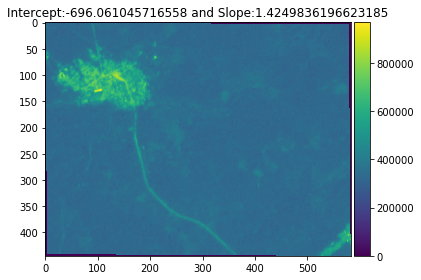

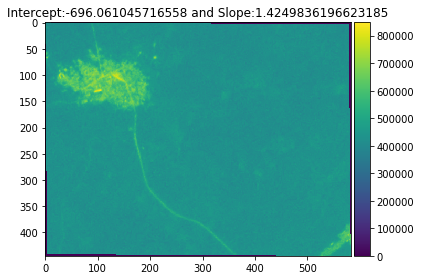

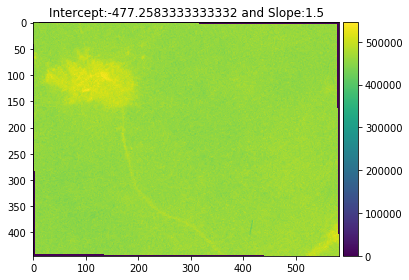

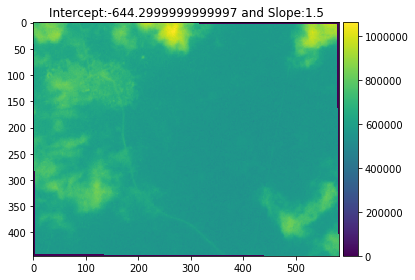

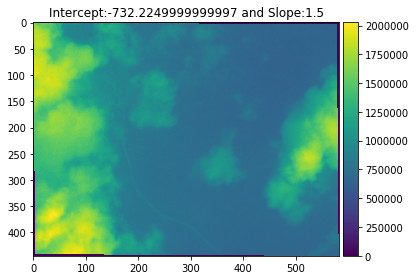

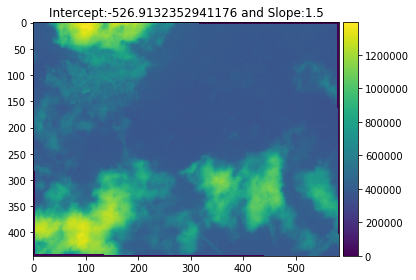

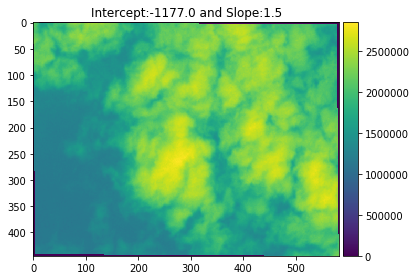

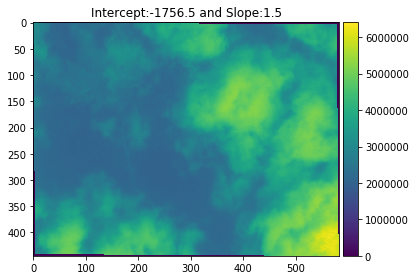

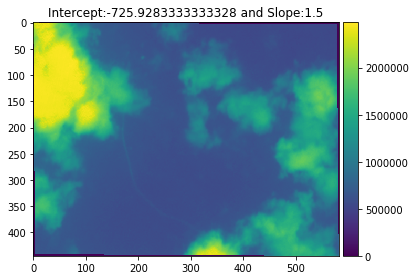

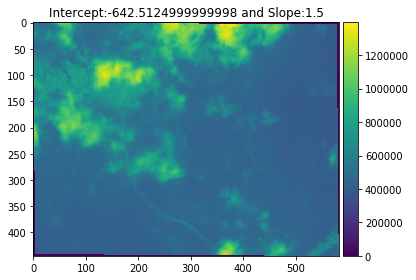

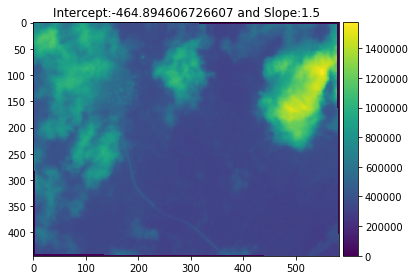

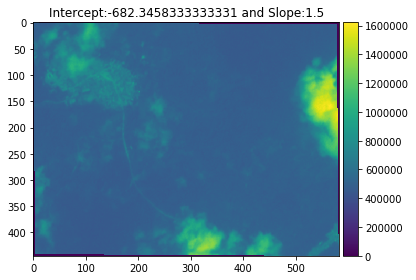

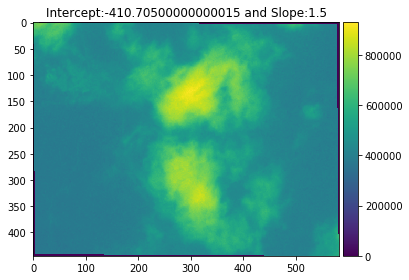

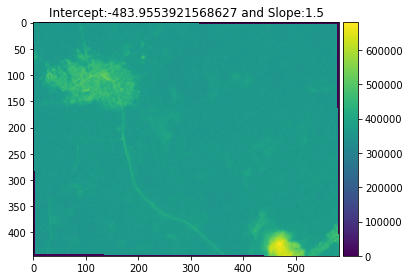

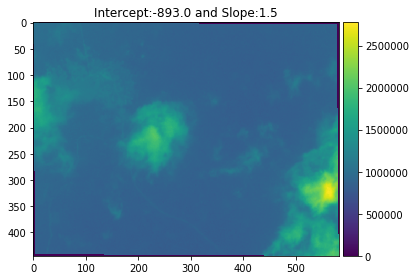

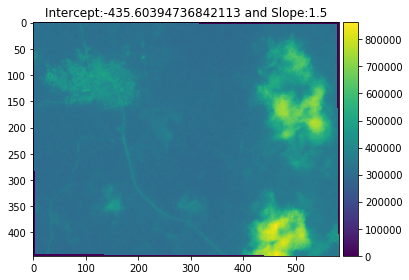

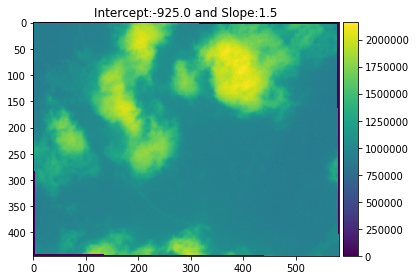

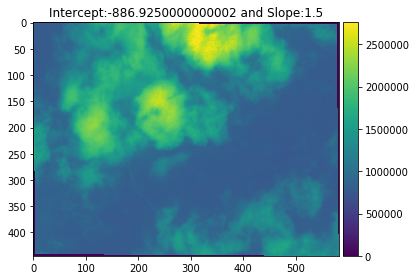

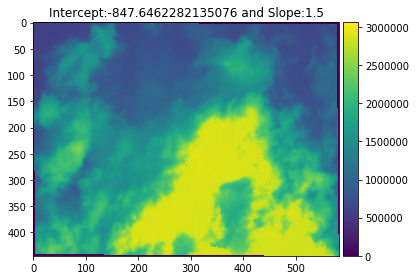

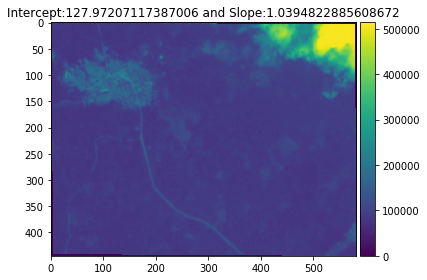

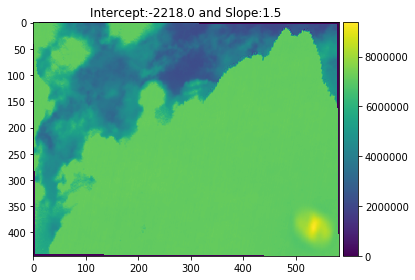

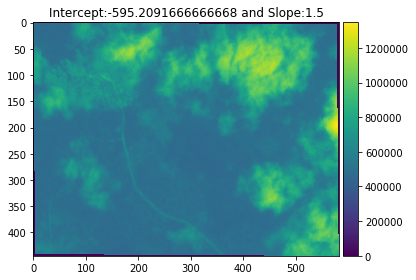

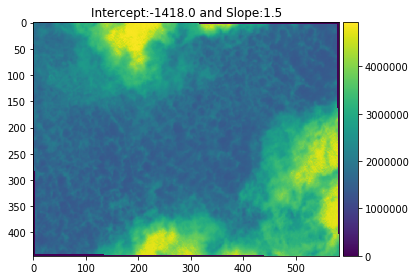

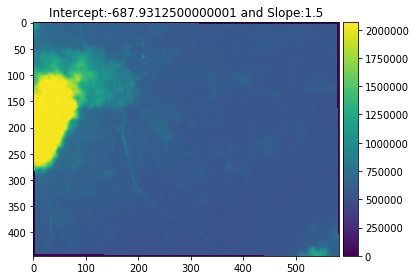

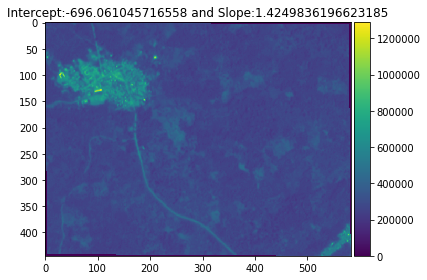

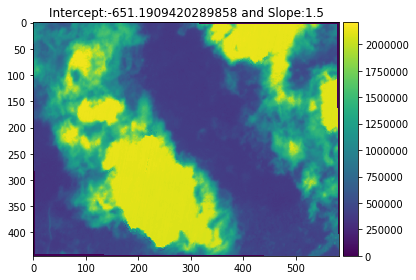

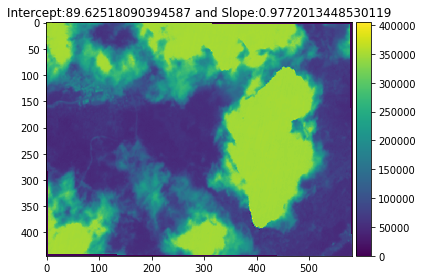

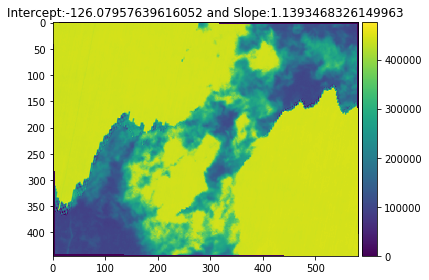

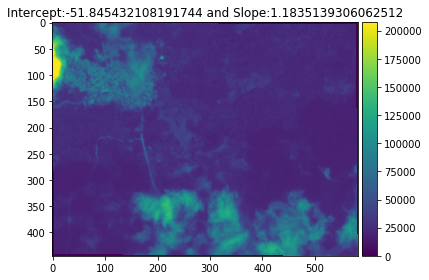

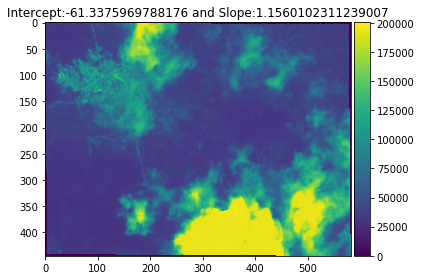

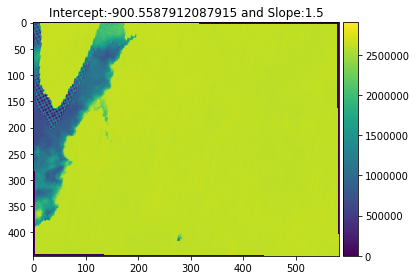

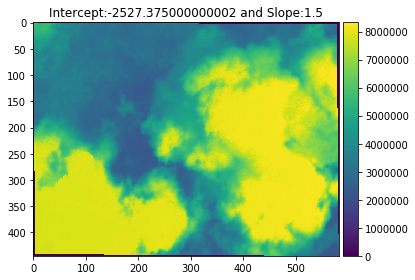

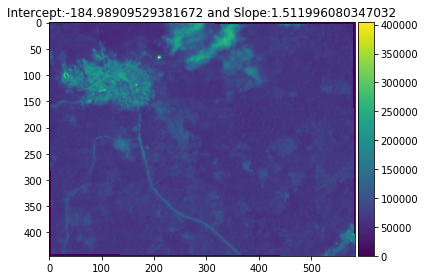

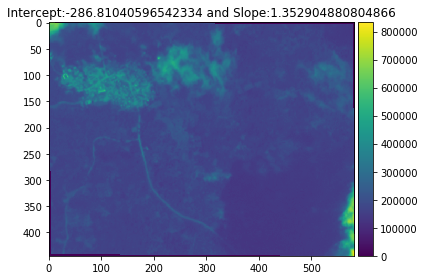

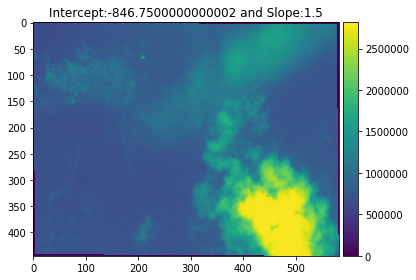

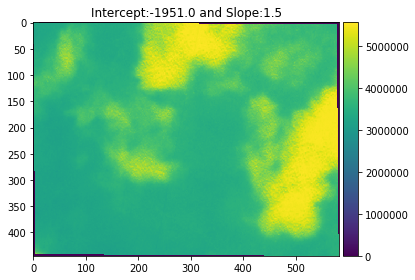

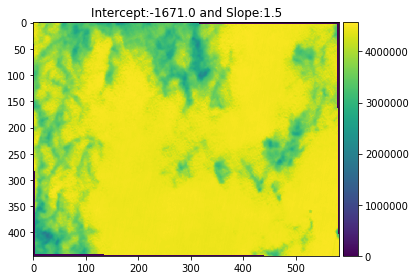

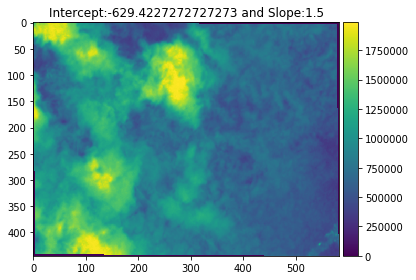

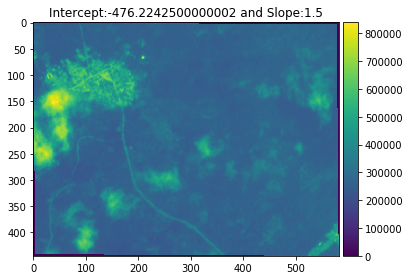

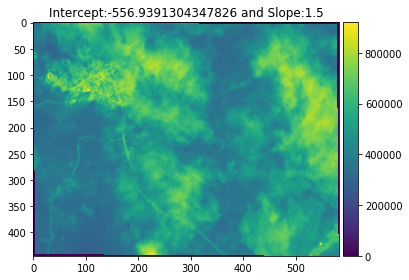

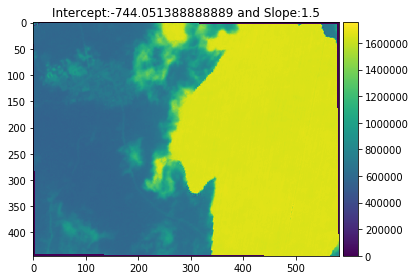

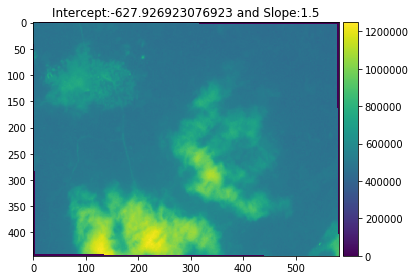

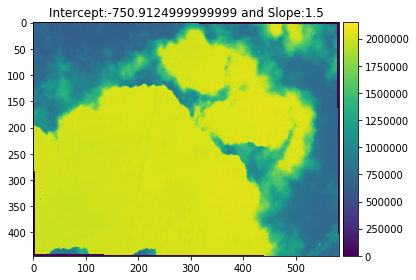

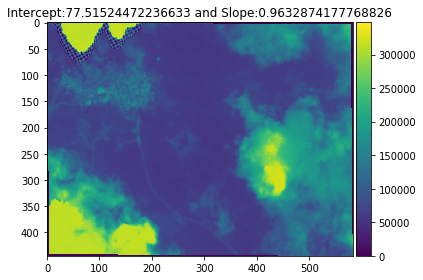

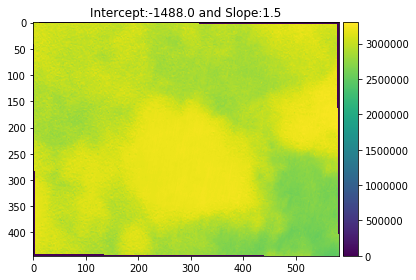

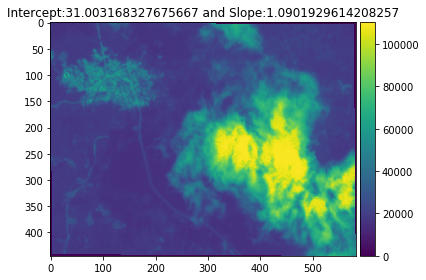

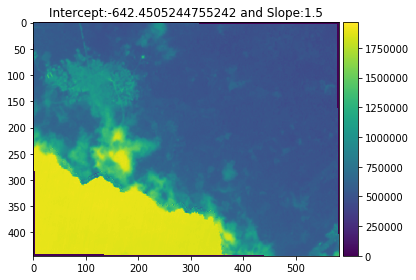

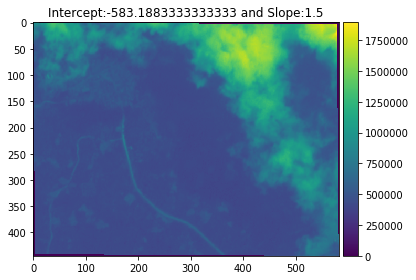

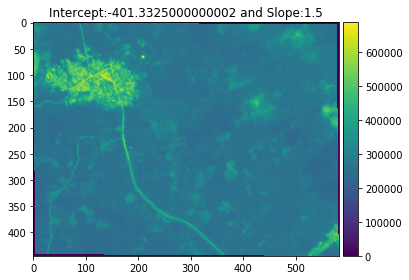

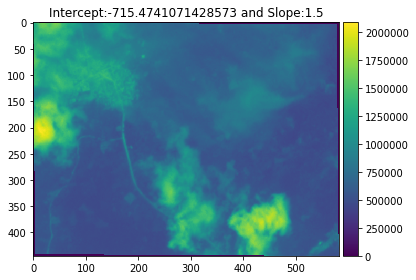

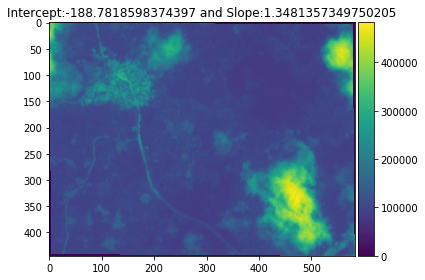

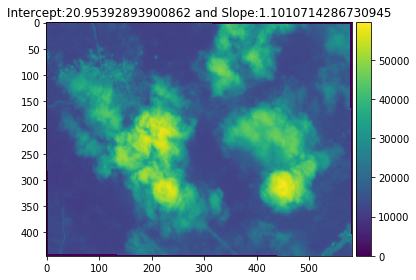

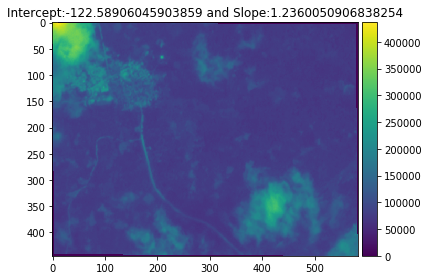

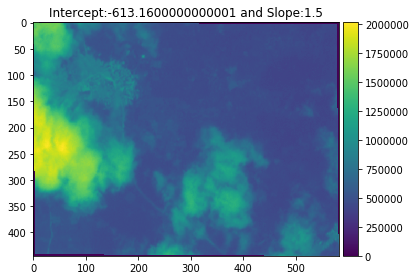

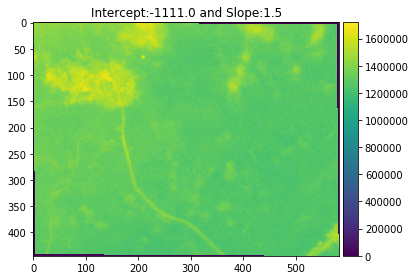

In [38]:
i = 0
while i<55:
    plt.figure()
    plt.title("Intercept:"+str(intercepts_slopes[i][0])+
              " and Slope:"+str(intercepts_slopes[i][1]))
    ski.io.imshow(hot_t_series[i,:,:])
    i+=1